In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy import integrate
import logging
from cvxopt import matrix, solvers
import networkx as nx
from itertools import repeat

# Data Loading

In [2]:
global train_inp, train_out, val_inp, val_out, test_inp, test_out, t
train_inp = np.load('train_inp.npy')
train_out = np.load('train_out.npy')
val_inp = np.load('val_inp.npy')
val_out = np.load('val_out.npy')
test_inp = np.load('test_inp.npy')
test_out = np.load('test_out.npy')
t = np.load('t.npy')

In [3]:
global n, N   #n is the number of nodes, N is the number of basis 
n = 12
N = 30
global REG
REG = "MCP"
global op_gamma_list, Lambda_list, Gamma_list, Rho_list, Beta_list
#best hyperparameters
op_gamma_list = [1.]   #gamma_op
Lambda_list = [1e-5]   #lambda
Gamma_list = [1e-6]    #gamma
Rho_list = [1e-2]      #rho_L
Beta_list = [1000.]    #rho_D

In [4]:
global num_train, num_val, num_test
num_train = len(train_inp)
num_val = len(val_inp)
num_test = len(test_inp)

# Basis Selection and Projection on basis functions with integration routine

In [5]:
def trig_basis():
    basis = []
    for i in range(N):
        if i == 0:
            b = (1./np.sqrt(t[-1]))*np.ones(len(t))
        else:
            b = np.sqrt(2./t[-1])*np.cos(np.pi*i*((1./t[-1])*t))
        basis.append(b)
    return basis

In [6]:
global basis
global k_mat
basis = trig_basis()

In [7]:
def get_proj_coefs(x):
    proj = np.zeros(N)
    for i in range(N):
        proj[i] = inner_prod(x, basis[i])
    return proj

In [8]:
def inner_prod(f, g):
    s = 0.
    num_t = len(f)
    x = t
    dx = (t[-1] - t[0])/(num_t-1)
    fx = f*g
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [9]:
def inner_prod_2d(mat, basis_i, basis_j):
    x = t
    num_t = len(t)
    dx = (t[-1] - t[0])/(num_t-1)
    s_t = np.zeros(num_t)
    for i in range(num_t):
        fx = mat[:,i]*basis_j
        s_t[i] = integrate.simps(fx, x, dx, even='avg')
    fx = s_t*basis_i
    s = integrate.simps(fx, x, dx, even='avg')
    return s

In [10]:
def exp_kernel_encoding(exp_mat):
    k_mat = np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            k_mat[i][j] = inner_prod_2d(exp_mat, basis[i], basis[j])
            if i!=j:
                k_mat[j][i] = k_mat[i][j]
    return k_mat

# Scalar and Operator-valued Kernel

In [11]:
def scalar_kernel_without_M_dup(f, g, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i]-g[i], f[j]-g[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [12]:
def scalar_inner_prod_without_M_dup(f, M_dup_c):
    inner_prod_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            inner_prod_matrix[i][j] = np.dot(f[i], f[j])
            if i!=j:
                inner_prod_matrix[j][i] = inner_prod_matrix[i][j]
    vec_inner_prod = inner_prod_matrix.flatten()
    r = np.zeros(int(n*(n+1)/2))
    for i in range(int(n*(n+1)/2)):
        c_ones = M_dup_c[i]
        for j in c_ones:
            if j!= -1:
                r[i] += vec_inner_prod[j]
    return r

In [13]:
def scalar_inner_prod_for_z(f, g):
    r = np.zeros(n)
    for i in range(n):
        r[i] = np.dot(f[i]-g[i], f[i]-g[i])
    return r

In [14]:
def scalar_kernel_calc(Gamma, R, vech_L, i, j):
    return i,j,np.exp(-Gamma*np.dot(R[i][j],vech_L))

In [15]:
def scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j):
    return np.exp(-Gamma*(np.dot(R[i][j],vech_L) + np.dot(Z[i][j], D)))

In [16]:
def scalar_G(vech_L, R, Gamma, D, Z):
    G = np.zeros((num_train,num_train))
    for i in range(num_train):
        for j in range(i, num_train):
            G[i][j] = scalar_kernel_calc_normal(Gamma, R, vech_L, D, Z, i, j)
            if i != j:
                G[j][i] = G[i][j]
    return G

In [17]:
def op_kernel(z, op_gamma):
    y = np.zeros(len(basis[0]))
    for i in range(len(basis)):
        y += z[i]*basis[i]
    one = np.ones(len(y))
    X = np.zeros(y.shape)
    for i in range(len(y)):
        s = t
        dx = t[-1]/(len(y)-1)
        f = np.multiply(np.exp(-op_gamma*np.abs(t[i]*one-s)),y)
        X[i] = integrate.simps(f, s, dx, even='avg')
    fX = get_proj_coefs(X)
    return fX

In [18]:
def op_kernel_modified(z, k_mat):
    return np.dot(k_mat,z)

In [19]:
def op_kernel_exp(op_gamma):
    exp_mat = np.zeros((len(t),len(t)))
    for i in range(len(t)):
        for j in range(len(t)):
            exp_mat[i][j] = np.exp(-op_gamma*(np.abs(t[i]-t[j])))
    return exp_mat

In [20]:
def op_K_normal(u, op_gamma):
    n1 = len(u)
    K = []
    for i in range(n1):
        K.append(op_kernel(u[i], op_gamma))
    return K

In [21]:
def op_K_normal_modified(u, k_mat):
    n1 = len(u)
    K = np.zeros((n1, N))
    for i in range(n1):
        K[i] = op_kernel_modified(u[i], k_mat)
    return K

In [22]:
def op_dot_A(G, v, op_gamma, Lambda):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal(v, op_gamma)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i,j]*(K[j]) + Lambda*(v[j])
            else:
                X += G[i,j]*(K[j])
        Av[i] = X
    return Av

In [23]:
def op_dot_A_modified(G, v, Lambda, k_mat):
    n1 = len(v)
    Av = np.zeros(v.shape)
    K = op_K_normal_modified(v, k_mat)
    for i in range(n1):
        X = 0.* v[0]
        for j in range(n1):
            if i == j:
                X += G[i][j]*(K[j]) + Lambda*(v[j])
            else:
                X += G[i][j]*(K[j])
        Av[i] = X
    return Av

# OpMINRES related functions

In [24]:
def LanczosStep(G, v1, v0, beta1, Lambda):
    p = op_dot_A_modified(G, v1, Lambda, k_mat)
    alpha = np.sum(np.multiply(v1,p))
    p = p - alpha*v1
    v2 = p - beta1*v0
    beta2 = np.linalg.norm(v2)
    if (beta2 != 0):
        v2 = (1./beta2)*v2
    return alpha, beta2, v2

In [25]:
def SymOrtho(a, b):
    if (b == 0):
        s = 0
        r = np.abs(a)
        if (a == 0):
            c = 1
        else:
            c = np.sign(a)
    elif (a == 0):
        c = 0
        s = np.sign(b)
        r = np.abs(b)
    elif (np.abs(b) > np.abs(a)):
        tau = a/b
        s = np.sign(b)/np.sqrt(1 + tau**2)
        c = s*tau
        r = b/s
    elif (np.abs(a) > np.abs(b)):
        tau = b/a
        c = np.sign(a)/np.sqrt(1 + tau**2)
        s = c*tau
        r = a/c
    return c, s, r

In [26]:
def OpMINRES(G, b, maxiter, tol, Lambda):
    beta1 = np.linalg.norm(b)
    n = len(b)
    v0 = np.zeros((n,N))
    v1 = (1./beta1)*b
    phi0 = beta1
    phi1 = beta1
    phi00 = beta1
    tau = beta1
    chi = 0
    delta1_1 = 0
    epsilon1_1 = 0
    c0 = -1
    s0 = 0
    d1 = np.zeros((n,N))
    d0 = np.zeros((n,N))
    x0 = np.zeros((n,N))
    k = 1
    x = []
    phi = []
    psi = []
    chi1 = []
    while(k <= maxiter and phi1/phi00 > tol):
        alpha, beta2, v2 = LanczosStep(G, v1, v0, beta1, Lambda)
        #last left orthogonaization on middle two entries in last column of T_k
        delta1_2 = c0*delta1_1 + s0*alpha
        gamma1_1 = s0*delta1_1 - c0*alpha
        #last left orthogonalization to produce first two entries of T_k+1e_k+1
        epsilon2_1 = s0*beta2
        delta2_1 = -c0*beta2
        #current left orthogonalization to zero out beta_k+1
        c1, s1, gamma1_2 = SymOrtho(gamma1_1, beta2)
        #right-hand side, residual norms
        tau = c1*phi0
        phi1 = s1*phi0
        psi0 = phi0*np.sqrt(gamma1_1**2 + delta2_1**2)
        if (gamma1_2 != 0):
            d2 = (1./gamma1_2)*(v1 - delta1_2*d1 - epsilon1_1*d0)
            x1 = x0 + tau*d2
            chi = np.linalg.norm(x1)
        k = k + 1
        v0 = v1
        v1 = v2
        beta1 = beta2
        c0 = c1
        s0 = s1
        phi0 = phi1
        delta1_1 = delta2_1
        epsilon1_1 = epsilon2_1
        x0 = x1
        d0 = d1
        d1 = d2
        x.append(x0)
        phi.append(phi0)
        psi.append(phi0*np.sqrt(gamma1_1**2 + delta2_1**2))
        chi1.append(chi)
    return x, phi, psi, chi1, k-1

#  M_dup, A, B, C computations

In [27]:
def determine_A_with_C(n):
    A = np.zeros((n+1,int(n*(n+1)/2)))
    l = 0
    for i in range(n):
        A[i][l:l+n-i] = np.ones(n-i)
        if(i == n-1):
            A[i][int(n*(n+1)/2)-1] = 1.
        k = 0
        for j in range(i):
            A[i][k+i] = 1.
            k += n - j -1
        l += n-i
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                A[-1,k] = 1
            k += 1
    return A

In [28]:
def fast_determine_M_dup_c_1(n, i):
    one1 = []
    n0 = n
    i0 = i
    q0 = 0
    r0 = 1
    for i in range(n):
        q = int(i0/n0)
        r = i0 % n0
        if q == 0:
            if r == 0:
                one1.append(q0)
                return one1
            else:
                one1.append(q0 + r)
                one1.append(q0 + r*n)
                return one1
        else:
            i0 -= n0
            n0 -= 1
            q0 += n + 1

In [29]:
def determine_A_r_1(n, i):
    one1 = []
    pos = i
    skip = n-1
    for j in range(n):
        if j < i:
            one1.append(pos)
            pos += skip
            skip -= 1
        else:
            one1.append(pos)
            pos += 1
    return one1

In [30]:
def determine_A_c_1(n, i):
    one1 = []
    pos = 0
    skip = n
    row = 0
    m = 1
    if i==0:
        one1.append(0)
        return one1
    else:
        for j in range(1,i+1):
            if j==skip:
                pos += 1
                if j==i:
                    one1.append(pos)
                    return one1
                row = pos
                skip += n-m
                m += 1
            else:
                row += 1
                if j==i:
                    one1.append(pos)
                    one1.append(row)
                    return one1

In [31]:
def determine_B(n):
    B = np.zeros((int(n*(n-1)/2),int(n*(n+1)/2)))
    if (n == 2):
        B = [1]
    else:
        j = n
        k = 1
        l = 0
        for i in range(int(n*(n-1)/2)):
            if(k == j):
                k = 1
                l += j
                j -= 1
            B[i][l+k] = 1.
            k += 1
    return B

In [32]:
def determine_C(n):
    C = np.zeros(int(n*(n+1)/2))
    k = 0
    for i in range(n):
        for j in range(n-i):
            if j == 0:
                C[k] = 1
            k += 1
    return C

# R matrix computation

In [33]:
def R_mat(t_inp, M_dup_c):
    R = np.zeros((num_train,num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        for j in range(i,num_train):
            R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_inp[j], M_dup_c)
            if i!=j:
                R[j][i] = R[i][j]
    return R

In [34]:
def R_l_loss(t_inp, M_dup_c):
    R = np.zeros((num_train,int(n*(n+1)/2)))
    for i in range(num_train):
        R[i] = scalar_inner_prod_without_M_dup(t_inp[i], M_dup_c)
    return R

In [35]:
def Z_mat(t_inp):
    Z = np.zeros((num_train, num_train, n))
    for i in range(num_train):
        for j in range(i, num_train):
            Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_inp[j])
            if i!=j:
                Z[j][i] = Z[i][j]
    return Z

# Regularizers

In [36]:
def h_mcp(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = Lambda_reg - x[i]/Gamma_reg
    return hx

In [37]:
def mcp_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_mcp(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

In [38]:
def h_scad(x):
    x = -x
    hx = np.zeros(int(n*(n+1)/2))
    for i in range(len(x)):
        if (x[i] >= 0):
            if (x[i] <= Lambda_reg):
                hx[i] = Lambda_reg
            elif(x[i] <= Gamma_reg*Lambda_reg):
                hx[i] = (Gamma_reg*Lambda_reg - x[i])/(Gamma_reg - 1)
    return hx

In [39]:
def scad_reg(x, C):
    diag = np.ones(int(n*(n+1)/2)) - C
    h = h_scad(x) 
    regularizer_grad = -np.multiply(diag, h)
    return regularizer_grad

# vech(L) <--> vec(L) conversion

In [40]:
def vech_to_vec(vech_L):
    m = len(vech_L)
    n = int((np.sqrt(1 + 8*m) - 1)/2)
    L = np.zeros((n,n))
    k = 0
    for i in range(n):
        L[i,i:] = vech_L[k:k+n-i]
        L[:,i] = L[i,:]
        k = k + n -i
    vec_L = L.flatten()
    return vec_L

In [41]:
def vec_to_vech(vec_L):
    m = len(vec_L)
    sq_m = int(np.sqrt(m))
    n = int((np.sqrt(m)*(np.sqrt(m)+1))/2)
    vech_L = np.zeros(n)
    k = 0
    l = 0
    for i in range(sq_m):
        vech_L[k:k+sq_m-i] = vec_L[l+i:l+sq_m]
        k = k + sq_m - i
        l = l + sq_m
    return vech_L

# Projection of Gradient

In [42]:
def grad_sum_proj_a(z, lambda_proj, mu_proj, ones_r):#not used #check for parallelization
    S = 0.
    for i in ones_r:
        S1 = 0.
        Ai_c_ones = determine_A_c_1(n, i)#check for n, needs to be passed 
        for p in Ai_c_ones:
            S1 += lambda_proj[p]
        S2 = 0.
        Bi_c_one = determine_B_c_1(n, i)
        if Bi_c_one != -1:
            S2 = mu_proj[Bi_c_one]
        S += (z[i]- S1 - S2)
    return S

In [43]:
def grad_sum_proj_b(z, lambda_proj, mu_proj, ones_r):#not used #check for parallelization
    S1 = 0.
    S2 = 0.
    Ai_c_ones = determine_A_c_1(n, ones_r)
    for p in Ai_c_ones:
        S1 += lambda_proj[p]
    Bi_c_one = determine_B_c_1(n, ones_r)
    if Bi_c_one != -1:
        S2 = mu_proj[Bi_c_one]
    S = (z[ones_r]- S1 - S2)
    return S

# Gradient calculation

In [44]:
def gradient_setup(Op_k, y, u):
    N1 = len(y)
    #R_x = np.zeros((N1,N1))
    Op_kk = np.zeros((N1,N1))
    y_k = np.zeros((N1,N1))
    k_u = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            if j>=i:
                Op_kk[i][j] = np.dot(Op_k[i], Op_k[j])
                if i!=j:
                    Op_kk[j][i] = Op_kk[i][j]
            y_k[i][j] = np.dot(y[i], Op_k[j])
            k_u[i][j] = np.dot(Op_k[i], u[j])
    return Op_kk, y_k, k_u

In [45]:
def gradient_J(x, y, u, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(int(n*(n+1)/2))
    S2 = np.zeros(int(n*(n+1)/2))
    S3 = np.zeros(int(n*(n+1)/2))
    S4 = np.zeros(int(n*(n+1)/2))
    R_x = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x) + np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 +  np.exp(-Gamma*(R_x[i][j]+R_x[i][k]))*Op_kk[j][k]*(R[i][j]+R[i][k]).T
            S1 = S1 + np.exp(-Gamma*R_x[i][j])*y_k[i][j]*R[i][j].T
            S3 = S3 + np.exp(-Gamma*R_x[i][j])*k_u[i][j]*R[i][j].T
        S4 = S4 + R_l[i].T
    S = 2*Gamma*S1 - Gamma*S2 - Lambda*Gamma*S3 + Rho*S4
    return S

In [46]:
def gradient_J_D(x, y, u, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D, Z):
    N1 = len(y)
    S1 = np.zeros(n)
    S2 = np.zeros(n)
    S3 = np.zeros(n)
    R_x = np.zeros((N1,N1))
    Z_D = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            R_x[i][j] = np.dot(R[i][j],x)
            Z_D[i][j] = np.dot(Z[i][j], D)
    for i in range(N1):
        for j in range(N1):
            for k in range(N1):
                S2 = S2 + np.exp(-Gamma*(R_x[i][j]+R_x[i][k]+(Z_D[i][j]+Z_D[i][k])))*Op_kk[j][k]*(Z[i][j]+Z[i][k]).T
            S1 = S1 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*y_k[i][j]*Z[i][j].T
            S3 = S3 + np.exp(-Gamma*(R_x[i][j]+ Z_D[i][j]))*k_u[i][j]*Z[i][j].T
    S = 2*Gamma*S1 - Gamma*S2 - Lambda*Gamma*S3 + 2*Beta*D
    return S

# Test & Loss Computations

In [47]:
def R_test(t_inp, t_test, M_dup_c):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_R = np.zeros((N1,N2,int(n*(n+1)/2)))
    for i in range(N1):
        for j in range(N2):
            test_R[i][j] = scalar_kernel_without_M_dup(t_inp[i], t_test[j], M_dup_c)
    return test_R

In [48]:
def Z_test(t_inp, t_test):
    N1 = len(t_inp)
    N2 = len(t_test)
    test_Z = np.zeros((N1,N2,n))
    for i in range(N1):
        for j in range(N2):
            test_Z[i][j] = scalar_inner_prod_for_z(t_inp[i], t_test[j])
    return test_Z

In [49]:
def test_loss(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, M_dup_c, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    return loss/n_test

# Plotting functions

In [50]:
def plot_predictions(test_inp_B, test_out_B, train_inp_B, vech_L, u, D, no_of_plots, title, Gamma, k_mat):
    n_test = len(test_inp_B)
    n_train = len(train_inp_B)
    test_R = R_test(train_inp_B, test_inp_B, M_dup_c)
    test_Z = Z_test(train_inp_B, test_inp_B)
    Op_k = op_K_normal_modified(u, k_mat)
    pred_test_out = 0.*test_out_B
    loss = 0.
    for i in range(n_test):
        for j in range(n_train):
            pred_test_out[i] = pred_test_out[i] + np.exp(-Gamma*(np.dot(test_R[j][i],vech_L)+np.dot(test_Z[j][i],D)))*Op_k[j]
        loss += np.linalg.norm(pred_test_out[i]-test_out_B[i])**2
    pred_test = []
    actual_test = []
    for i in range(n_test):
        pred = np.zeros(len(basis[0]))
        act = np.zeros(len(basis[0]))
        for j in range(N):
            pred = pred + pred_test_out[i][j]*basis[j]
            act = act + test_out_B[i][j]*basis[j]
        actual_test.append(act)
        pred_test.append(pred)
    fig, axes = plt.subplots(int(no_of_plots/4),4, sharex=True, sharey=True, figsize=(20, 10))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flatten()):
        ax.plot(t, pred_test[i], t, actual_test[i])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels=['Predicted', 'Actual'])
    plt.show()
    print(loss)

# Main Implementation

In [51]:
m_trace = np.ceil(n/2)
Lambda_reg = 0.5
Gamma_reg = 1.
start_eta = 1e-4
end_eta = 1e-9
E1 = 1e-3
E2 = 1e-3
E3 = 1e-3
E_D = 1e-3
start_eta_D = 1e-4
end_eta_D = 1e-9
train_out_B = np.zeros((len(train_out),N))
for s in range(len(train_out)):
    train_out_B[s] = get_proj_coefs(train_out[s])
train_inp_B = np.zeros((len(train_out), n, N))
for s1 in range(num_train):
    for s2 in range(len(train_inp[0])):
        train_inp_B[s1][s2] = get_proj_coefs(train_inp[s1][s2])
val_out_B = np.zeros((len(val_out),N))
for s in range(len(val_out)):
    val_out_B[s] = get_proj_coefs(val_out[s])
val_inp_B = np.zeros((len(val_out), n, N))
for s1 in range(num_val):
    for s2 in range(len(val_inp[0])):
        val_inp_B[s1][s2] = get_proj_coefs(val_inp[s1][s2])
test_out_B = np.zeros((len(test_out),N))
for s in range(len(test_out)):
    test_out_B[s] = get_proj_coefs(test_out[s])
test_inp_B = np.zeros((len(test_out), n, N))
for s1 in range(num_test):
    for s2 in range(len(test_inp[0])):
        test_inp_B[s1][s2] = get_proj_coefs(test_inp[s1][s2])
np.save('train_inp_B_12.npy', train_inp_B)
np.save('train_out_B_12.npy', train_out_B)
np.save('val_inp_B_12.npy', val_inp_B)
np.save('val_out_B_12.npy', val_out_B)
np.save('test_inp_B_12.npy', test_inp_B)
np.save('test_out_B_12.npy', test_out_B)
np.save('t.npy', t)
A = determine_A_with_C(n)
B = determine_B(n)
C = determine_C(n)
M_dup_c = np.zeros((int(n*(n+1)/2),2))
for s1 in range(int(n*(n+1)/2)):
    col = np.asarray(fast_determine_M_dup_c_1(n, s1))
    if len(col) == 1:
        M_dup_c[s1][0] = col[0]
        M_dup_c[s1][1] = -1
    else:
        M_dup_c[s1] = col
M_dup_c = M_dup_c.astype(int)
R = R_mat(train_inp_B, M_dup_c)
np.save('R_12', R)
R_l = R_l_loss(train_inp_B, M_dup_c)
np.save('R_l_12', R_l)
Z = Z_mat(train_inp_B)
print("setup complete!")
solvers.options['show_progress'] = False
val_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
train_err_mat = 10000*np.ones((len(op_gamma_list),len(Lambda_list),len(Gamma_list),len(Rho_list),len(Beta_list)))
vech_L_list = []
u_list = []
D_list = []
i_op = 0
for op_gamma in op_gamma_list:
    i_lambda = 0
    k_mat = exp_kernel_encoding(op_kernel_exp(op_gamma))
    for Lambda in Lambda_list:
        i_gamma = 0
        for Gamma in Gamma_list:
            i_rho = 0
            for Rho in Rho_list:
                i_beta = 0
                for Beta in Beta_list:
                    L = np.eye(n)
                    D = np.ones(n)
                    for s in range(n):
                        L[s][s] = m_trace/n
                        for s1 in range(s+1,n):
                            L[s][s1] = -L[s][s]/(n-1)
                            L[s1][s] =  L[s][s1]
                    vec_L = L.flatten()
                    vech_L = vec_to_vech(vec_L)
                    u_error = E1+1
                    patience = 5
                    i = 1
                    print("Iteration: op_gamma:",op_gamma," Lambda:", Lambda," Gamma:", Gamma," Rho:", Rho," Beta:", Beta)
                    print("===================================================================")
                    #main_loop
                    while(u_error >= E1 and i<=50):
                        G = scalar_G(vech_L, R, Gamma, D, Z)
                        u, phi, psi, chi, k = OpMINRES(G, train_out_B, 1000, 1e-3, Lambda)
                        u_ = u[k-1]
                        Op_k = op_K_normal_modified(u_, k_mat)
                        j = 1
                        vech_L_error = E2+1
                        if i==1 and j == 1:
                            vech_L_ = (m_trace/(n*(n-1)))*np.ones(int(n*(n+1)/2))
                            pos = 0
                            for s in range(n):
                                vech_L_[pos+s] = m_trace/n
                                pos += n-s-1
                        patience_count = 0
                        Op_kk, y_k, k_u = gradient_setup(Op_k, train_out_B, u_)
                        eta = start_eta
                        #vech(L) loop
                        while(vech_L_error >= E2 and j<=100):
                            grad_J = gradient_J(vech_L_, train_out_B, u_, R, R_l, C, Gamma, Lambda, Rho, m_trace, Op_kk, y_k, k_u, D, Z)
                            x_k = vech_L_ - eta*grad_J
                            l = 0
                            vech_L_reg_error = E3 + 1
                            if REG == "None":
                                m_trace_0_vec = np.zeros(n+1)
                                m_trace_0_vec[-1] = m_trace
                                Q = matrix(2*np.eye(int(n*(n+1)/2)))
                                p = matrix(-2*x_k)
                                G = matrix(B)
                                h = matrix(np.zeros(int(n*(n-1)/2)))
                                A = matrix(A)
                                b = matrix(m_trace_0_vec)
                                sol = solvers.qp(Q, p, G, h, A, b)
                                vech_L = np.array(sol['x'])
                                vech_L = np.squeeze(vech_L)
                            else:
                                while(vech_L_reg_error >= E3 and l <= 1000):
                                    if REG == "MCP":
                                        h = mcp_reg(vech_L_, C)
                                        p = matrix(-2*x_k + h)
                                    elif REG == "SCAD":
                                        h = scad_reg(vech_L_, C)
                                        p = matrix(-2*x_k + h)
                                    m_trace_0_vec = np.zeros(n+1)
                                    m_trace_0_vec[-1] = m_trace
                                    Q = matrix(2*np.eye(int(n*(n+1)/2)))     #2 included to balance h term
                                    G = matrix(B)
                                    h = matrix(np.zeros(int(n*(n-1)/2)))
                                    A = matrix(A)
                                    b = matrix(m_trace_0_vec)
                                    sol = solvers.qp(Q, p, G, h, A, b)
                                    vech_L = np.array(sol['x'])
                                    vech_L = np.squeeze(vech_L)
                                    vech_L_reg_error = np.linalg.norm(vech_L - vech_L_)
                                    vech_L_ = vech_L
                                    l += 1
                            vech_L_error = np.linalg.norm(vech_L-vech_L_)
                            vech_L_ = vech_L
                            if j%5 == 0:
                                eta = eta/2
                            if eta < end_eta:
                                eta = end_eta
                            j += 1
                        i_D = 1
                        D_error = E_D + 1
                        D_ = D
                        if i==1 and j==1 and k==1:
                            D_ = np.ones(n)
                        eta_D = start_eta_D
                        #vech(D) loop
                        while(D_error >= E_D and i_D <= 100):
                            grad_J_D = gradient_J_D(vech_L, train_out_B, u_, R, Gamma, Lambda, Beta, Op_kk, y_k, k_u, D_, Z)
                            D = D_ - eta_D*grad_J_D
                            D[D < 0.] = 0.
                            D_error = np.linalg.norm(D-D_)
                            D_ = D
                            if i_D%5 == 0:
                                eta_D = eta_D/2
                            if eta_D < end_eta_D:
                                eta_D = end_eta_D
                            i_D += 1
                        if i == 1:
                            u_error = E1 + 1
                        else:
                            u_error = np.linalg.norm(u_-u_1)
                        u_1 = u_
                        i += 1
                    print("i, j, l, i_D : (", i-1,",", j-1,",",l-1,",",i_D-1,")")
                    print("Algo finished")
                    loss = test_loss(train_inp_B, train_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                    print("Training loss after complete iteration: ", loss)
                    val_l = test_loss(val_inp_B, val_out_B, train_inp_B, vech_L, u_, D, M_dup_c, Gamma, k_mat)
                    print("Validation loss after complete iteration: ", val_l)
                    D_list.append(D)
                    vech_L_list.append(vech_L)
                    u_list.append(u_)
                    train_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = loss
                    val_err_mat[i_op][i_lambda][i_gamma][i_rho][i_beta] = val_l
                    i_beta += 1
                i_rho += 1
            i_gamma += 1
        i_lambda += 1
    i_op += 1
err_mat_argmin = np.unravel_index(val_err_mat.argmin(), val_err_mat.shape)
print("==============================================================================")
print("Best op_gamma: ", op_gamma_list[err_mat_argmin[0]])
print("Best Lambda: ", Lambda_list[err_mat_argmin[1]])
print("Best Gamma: ", Gamma_list[err_mat_argmin[2]])
print("Best Rho: ", Rho_list[err_mat_argmin[3]])
print("Best Beta: ", Beta_list[err_mat_argmin[4]])
print("Best validation error value:", val_err_mat[err_mat_argmin])
print("Best training error value:", train_err_mat[err_mat_argmin])
print(err_mat_argmin)

setup complete!
Iteration: op_gamma: 1.0  Lambda: 1e-05  Gamma: 1e-06  Rho: 0.01  Beta: 1000.0
i, j, l, i_D : ( 50 , 1 , 0 , 1 )
Algo finished
Training loss after complete iteration:  1.140695523983674
Validation loss after complete iteration:  1.7804698868111568
Best op_gamma:  1.0
Best Lambda:  1e-05
Best Gamma:  1e-06
Best Rho:  0.01
Best Beta:  1000.0
Best validation error value: 1.7804698868111568
Best training error value: 1.140695523983674
(0, 0, 0, 0, 0)


In [52]:
print(val_err_mat)
print(op_gamma_list[err_mat_argmin[0]])
print(Lambda_list[err_mat_argmin[1]])
print(Gamma_list[err_mat_argmin[2]])
print(Rho_list[err_mat_argmin[3]])
print(Beta_list[err_mat_argmin[4]])
print(err_mat_argmin)
best_index = err_mat_argmin[0]*(len(Lambda_list)*len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[1]*(len(Gamma_list)*len(Rho_list)*len(Beta_list))+err_mat_argmin[2]*(len(Rho_list)*len(Beta_list))+err_mat_argmin[3]*(len(Beta_list))+err_mat_argmin[4]
print(best_index)
val_err_mat_flat = val_err_mat.flatten()
print(val_err_mat_flat[best_index])
best_D = D_list[best_index]
best_vech_L = vech_L_list[best_index]
best_u = u_list[best_index]
best_Gamma = Gamma_list[err_mat_argmin[2]]
best_op_gamma = op_gamma_list[err_mat_argmin[0]]
print("Best validation error: ",val_err_mat[err_mat_argmin])
print("Best training error: ", train_err_mat[err_mat_argmin])
k_mat = exp_kernel_encoding(op_kernel_exp(best_op_gamma))
test_err = test_loss(test_inp_B, test_out_B, train_inp_B, best_vech_L, best_u, best_D, M_dup_c, best_Gamma, k_mat)
print("Best test error: ", test_err)

[[[[[1.78046989]]]]]
1.0
1e-05
1e-06
0.01
1000.0
(0, 0, 0, 0, 0)
0
1.7804698868111568
Best validation error:  1.7804698868111568
Best training error:  1.140695523983674
Best test error:  1.5836449004321458


In [53]:
np.save('best_D_sparse_opminres-l-d_80_20_20.npy', best_D)
np.save('best_vech_L_sparse_opminres-l-d_80_20_20.npy', best_vech_L)
np.save('best_u_sparse_opminres-l-d_80_20_20.npy', best_u)

In [54]:
#trace
trace = 0.
j = 0
for i in range(n):
    trace += vech_L[j]
    j += n - i
print(trace)

6.0


/tmp/ipykernel_1474415/1585258999.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(handles, labels=['Predicted', 'Actual'])


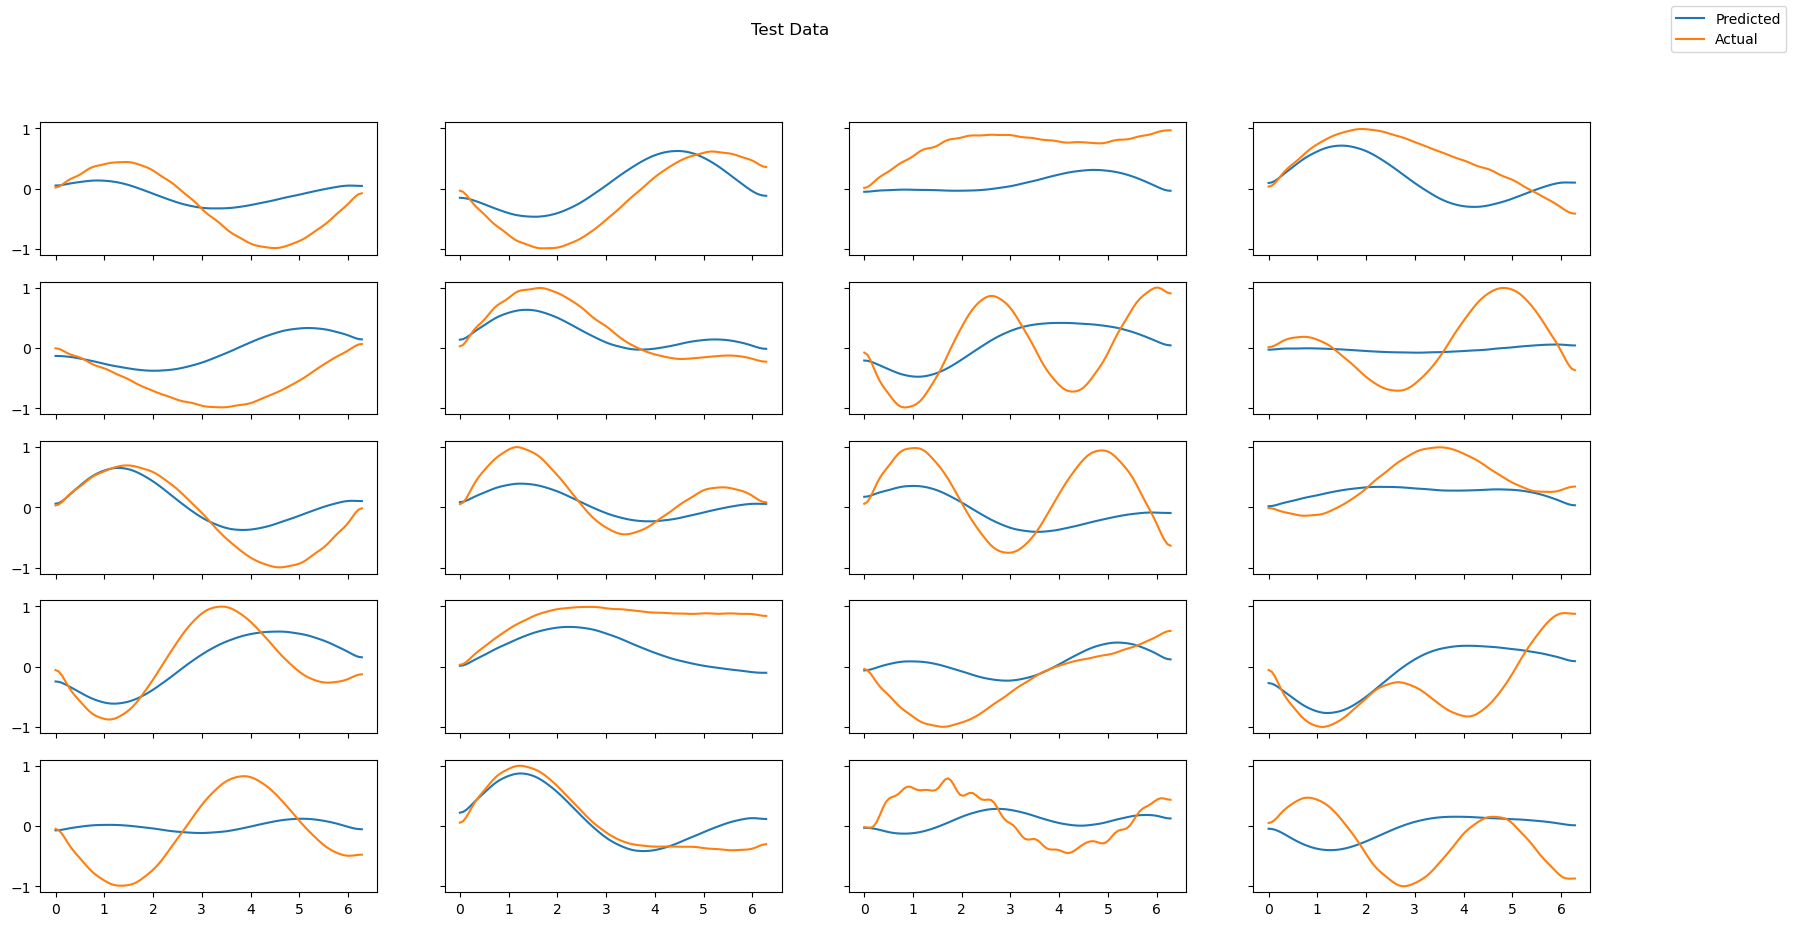

31.672898008642917


In [55]:
plot_predictions(test_inp_B, test_out_B, train_inp_B, best_vech_L, best_u, best_D, 20, 'Test Data', best_Gamma, k_mat)

In [56]:
vec_L = vech_to_vec(best_vech_L)
L = vec_L.reshape((n,n))
print(L)

[[ 7.50309933e-01 -9.93436162e-09 -1.00567904e-08 -7.50309816e-01
  -9.84687957e-09 -9.91608159e-09 -1.46634820e-08 -1.02634204e-08
  -1.01105705e-08 -1.39904435e-08 -1.39168714e-08 -1.40627020e-08]
 [-9.93436162e-09  7.60737664e-01 -9.86326130e-09 -9.92919858e-09
  -9.57192595e-09 -7.60737551e-01 -1.37750877e-08 -9.95522612e-09
  -9.66253743e-09 -1.36831080e-08 -1.35894452e-08 -1.37236847e-08]
 [-1.00567904e-08 -9.86326130e-09  7.53957910e-01 -1.00573508e-08
  -9.29528286e-09 -9.90246342e-09 -1.39331697e-08 -7.53957798e-01
  -9.34866651e-09 -1.30771161e-08 -1.30007037e-08 -1.31943306e-08]
 [-7.50309816e-01 -9.92919858e-09 -1.00573508e-08  7.50309933e-01
  -9.83832057e-09 -9.90183576e-09 -1.45986834e-08 -1.02533184e-08
  -1.00949067e-08 -1.39204020e-08 -1.38577818e-08 -1.39890040e-08]
 [-9.84687957e-09 -9.57192595e-09 -9.29528286e-09 -9.83832057e-09
   7.34994220e-01 -9.58017052e-09 -1.32930132e-08 -9.35223717e-09
  -7.34994111e-01 -1.29027480e-08 -1.28781134e-08 -1.30315823e-08]
 [-9.

In [57]:
def display_graph_with_thresh(vech_L, c_num):
    vec_L = vech_to_vec(vech_L)
    L = vec_L.reshape((n,n))
    W = np.diag(np.diag(L)) - L
    G = nx.Graph()
    for i in range(len(W)):
        G.add_node(i+1)
    for i in range(n):
        for j in range(i+1,n):
            if W[i][j] > 0:
                G.add_edge(i+1, j+1, weight=np.log10(W[i][j]))
    plt.figure()
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, pos, font_color = 'white', node_shape = 'o', with_labels = True, node_color='b', edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues)
    sorted_weights = sorted(weights)
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = plt.cm.Blues
    bounds = np.arange(-c_num,1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=ax,
        boundaries=bounds,
        ticks=bounds,
        spacing='proportional',
        orientation='horizontal',
        label= 'Log scale',
    )

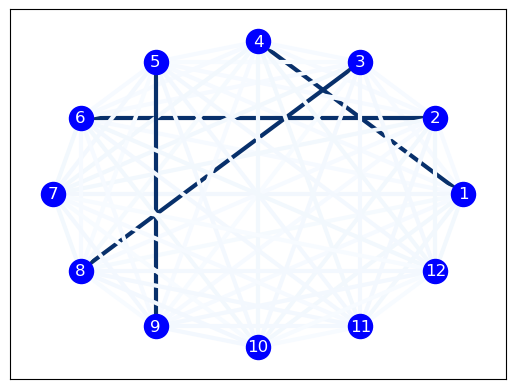

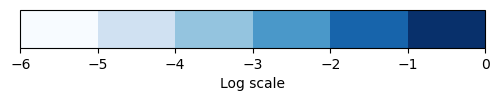

In [58]:
display_graph_with_thresh(best_vech_L, 6)

In [59]:
print(best_D)

[0.03590706 0.02525212 0.01055801 0.03438789 0.01114784 0.02603669
 0.02417173 0.01043979 0.00945197 0.00061842 0.00041893 0.00054514]


In [60]:
best_vech_L = np.load('best_vech_L_sparse_opminres-l-d_80_20_20.npy')
print(best_vech_L)

[ 7.50309933e-01 -9.93436162e-09 -1.00567904e-08 -7.50309816e-01
 -9.84687957e-09 -9.91608159e-09 -1.46634820e-08 -1.02634204e-08
 -1.01105705e-08 -1.39904435e-08 -1.39168714e-08 -1.40627020e-08
  7.60737664e-01 -9.86326130e-09 -9.92919858e-09 -9.57192595e-09
 -7.60737551e-01 -1.37750877e-08 -9.95522612e-09 -9.66253743e-09
 -1.36831080e-08 -1.35894452e-08 -1.37236847e-08  7.53957910e-01
 -1.00573508e-08 -9.29528286e-09 -9.90246342e-09 -1.39331697e-08
 -7.53957798e-01 -9.34866651e-09 -1.30771161e-08 -1.30007037e-08
 -1.31943306e-08  7.50309933e-01 -9.83832057e-09 -9.90183576e-09
 -1.45986834e-08 -1.02533184e-08 -1.00949067e-08 -1.39204020e-08
 -1.38577818e-08 -1.39890040e-08  7.34994220e-01 -9.58017052e-09
 -1.32930132e-08 -9.35223717e-09 -7.34994111e-01 -1.29027480e-08
 -1.28781134e-08 -1.30315823e-08  7.60737665e-01 -1.38543791e-08
 -9.98103686e-09 -9.69083814e-09 -1.37113091e-08 -1.36067346e-08
 -1.37442364e-08  1.39730736e-07 -1.39171507e-08 -1.32287086e-08
 -9.38838438e-09 -9.57460